In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/miniconda3/envs/zoonosis/lib/python311.zip',
 '/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11',
 '/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/lib-dynload',
 '',
 '/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../..']

In [2]:
#!pip install seaborn==0.13.0

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [12]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import textwrap
from statistics import mean
from scipy.stats import mannwhitneyu
from src.utils import utils, evaluation_utils, visualization_utils

In [3]:
def read_dataset(file_paths):
    dfs= []
    for model, file_path in file_paths.items():
        df = pd.read_csv(file_path, index_col=0)
        df["model"] = model
        dfs.append(df)
    return pd.concat(dfs)


def compute_class_distribution(df, label_col, n, format=False):
    labels_counts = df[label_col].value_counts()
    labels_counts = labels_counts / n * 100
    labels_counts = labels_counts.to_dict()
    if format:
        labels_counts = {k: f"{k}\n({v:.2f}%)" for k, v, in labels_counts.items()}
    labels_counts["Xiphophorus malinche x Xiphophorus birchmanni"] = "Xiphophorus birchmanni\n(0.02%)"
    return labels_counts

In [4]:
file_paths = {
    "3-way, 5-shot": os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240928/host_multi/few_shot_learning/fsl_tr_w3s5q10_te_w3s5q-1_e100b32_split70-10-20_hybrid-attention_sl256st64vs30cls_fnn_2l_d1024_lr1e-4_classwise_auprc.csv"),
    "3-way, 4-shot": os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240928/host_multi/few_shot_learning/fsl_tr_w3s4q10_te_w3s4q-1_e100b32_split70-10-20_hybrid-attention_sl256st64vs30cls_fnn_2l_d1024_lr1e-4_classwise_auprc.csv"),
    "3-way, 3-shot": os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240928/host_multi/few_shot_learning/fsl_tr_w3s3q10_te_w3s3q-1_e100b32_split70-10-20_hybrid-attention_sl256st64vs30cls_fnn_2l_d1024_lr1e-4_classwise_auprc.csv"),
    "3-way, 2-shot": os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240928/host_multi/few_shot_learning/fsl_tr_w3s2q10_te_w3s2q-1_e100b32_split70-10-20_hybrid-attention_sl256st64vs30cls_fnn_2l_d1024_lr1e-4_classwise_auprc.csv"),
    "3-way, 1-shot": os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240928/host_multi/few_shot_learning/fsl_tr_w3s1q10_te_w3s1q-1_e100b32_split70-10-20_hybrid-attention_sl256st64vs30cls_fnn_2l_d1024_lr1e-4_classwise_auprc.csv"),
    "5-way, 5-shot": os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240928/host_multi/few_shot_learning/fsl_tr_w5s5q10_te_w5s5q-1_e100b32_split70-10-20_hybrid-attention_sl256st64vs30cls_fnn_2l_d1024_lr1e-4_classwise_auprc.csv"),
    "4-way, 5-shot": os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240928/host_multi/few_shot_learning/fsl_tr_w4s5q10_te_w4s5q-1_e100b32_split70-10-20_hybrid-attention_sl256st64vs30cls_fnn_2l_d1024_lr1e-4_classwise_auprc.csv"),
}

shot_var_models = ["3-way, 5-shot", "3-way, 4-shot", "3-way, 3-shot", "3-way, 2-shot", "3-way, 1-shot"]
way_var_models = ["3-way, 5-shot", "4-way, 5-shot", "5-way, 5-shot"]
dataset_file_path = os.path.join(os.getcwd(), "..","..", "..", "input/data/uniref90/20240131/uniref90_viridae_embl_hosts_pruned_metadata_species_vertebrates_w_seq_non_idv_lt_1_gte_0.05_prcnt_prevalence_seq_len_in_99prcntile.csv")

In [6]:
df = read_dataset(file_paths)

In [7]:
df[(df["model"] == "3-way, 5-shot") & (df["itr"] == 0)]["class"].nunique()

28

In [8]:
dataset_df = pd.read_csv(dataset_file_path)
metadata_unformatted = compute_class_distribution(dataset_df, "virus_host_name", n=47792, format=False)

In [9]:
metadata_unformatted

{'Cyprinus carpio': 0.8578841647137595,
 'Petroica australis': 0.8536993639102779,
 'Felis catus': 0.6214429193170405,
 'Gopherus morafkai': 0.610980917308336,
 'Peromyscus boylii': 0.5900569132909274,
 'Marmota flaviventris': 0.5670405088717777,
 'Bos taurus': 0.5356545028456646,
 'Eptesicus fuscus': 0.5314697020421828,
 'Macaca mulatta': 0.48543689320388345,
 'Loxodonta africana': 0.4456812855708068,
 'Mastomys natalensis': 0.4331268831603616,
 'Gymnorhina tibicen': 0.4059256779377301,
 'Eidolon helvum': 0.3766320723133579,
 'Sparus aurata': 0.36826247070639434,
 'Ailurus fulgens': 0.3640776699029126,
 'Elephas maximus': 0.35989286909943086,
 'Oryzomys sp.': 0.33478406427854035,
 'Lates calcarifer': 0.33059926347505864,
 'Bufo bufo': 0.3180448610646133,
 'Crocodylus porosus': 0.31595246066287247,
 'Hypsugo savii': 0.305490458654168,
 'Equus caballus': 0.305490458654168,
 'Dipodomys merriami': 0.30339805825242716,
 'Rattus norvegicus': 0.2950284566454637,
 'Crocodilurus amazonicus': 0

In [10]:
df["prevalence"] = df["class"].apply(lambda x: metadata_unformatted[x])

In [11]:
df

,class,auprc,itr,model,prevalence
0,Gorilla gorilla,0.228279,0,"3-way, 5-shot",0.115082
1,Mastomys natalensis,0.889177,0,"3-way, 5-shot",0.433127
2,Miniopterus pusillus,0.549528,0,"3-way, 5-shot",0.056495
3,Ailurus fulgens,0.984618,0,"3-way, 5-shot",0.364078
4,Gymnorhina tibicen,0.966904,0,"3-way, 5-shot",0.405926
...,...,...,...,...,...
395,Phoenicurus auroreus,0.577531,4,"4-way, 5-shot",0.092066
396,Bufo bufo,0.418547,4,"4-way, 5-shot",0.318045
397,Corynorhinus rafinesquii,0.322819,4,"4-way, 5-shot",0.064864
398,Mastomys natalensis,0.555695,4,"4-way, 5-shot",0.433127


<Figure size 432x288 with 0 Axes>

<Figure size 1440x2160 with 0 Axes>

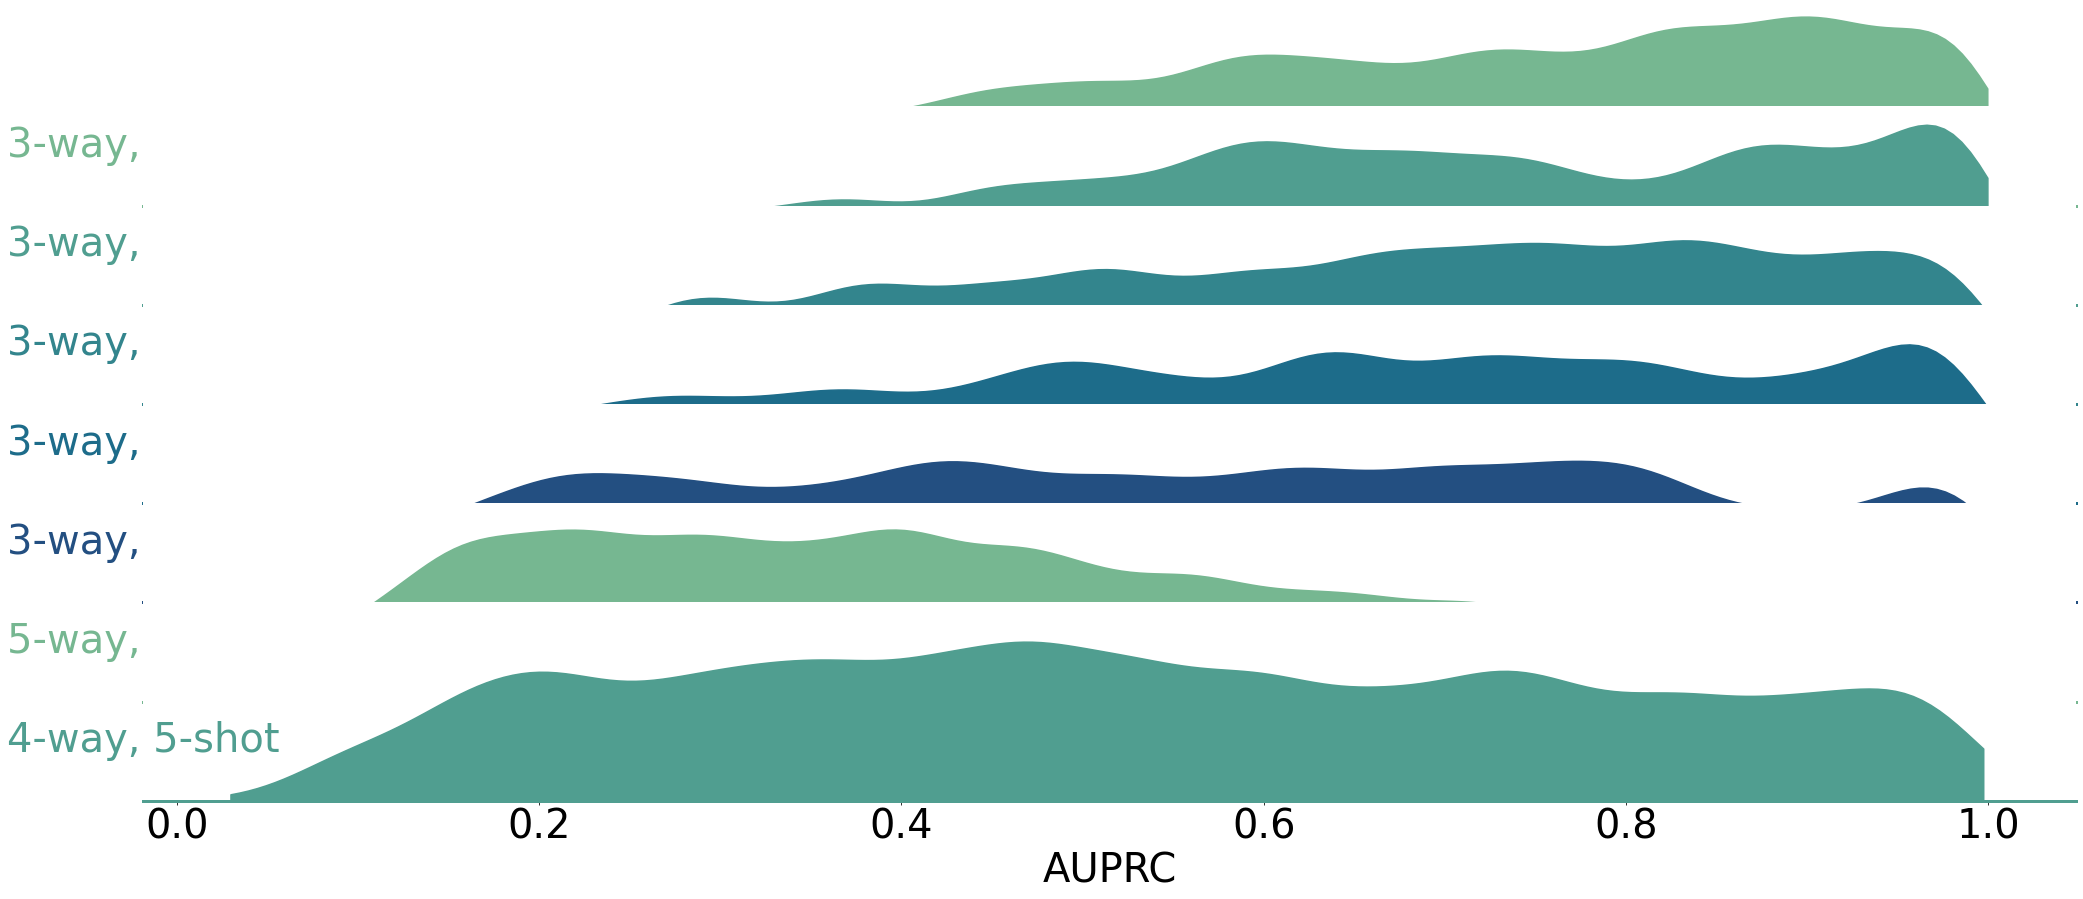

In [12]:
plt.clf()
plt.figure(figsize=(20, 30))
plt.rcParams["xtick.labelsize"] = 40
plt.rcParams["ytick.labelsize"] = 40
plt.rcParams.update({'font.size': 40})

pal = sns.cubehelix_palette(5, rot=-.25, light=.7)
palette = sns.color_palette("crest", 5)
g = sns.FacetGrid(df, row="model", hue="model", aspect=15, height=2, palette=palette, sharex=True)

# Draw the densities in a few steps
g.map(sns.kdeplot, "auprc",
      bw_adjust=.5, clip_on=False, cut=0,
      linewidth=1.5, fill=True, alpha=1)
g.map(sns.kdeplot, "auprc", 
      bw_adjust=.5, clip_on=False, cut=0,
      color="w", linewidth=.00001)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=3, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(-.07, .3, label, color=color,
            ha="left", va="center", transform=ax.transAxes)



g.map(label, "auprc")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.5)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.xlabel("AUPRC")
#g.figure.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "..","..", "..", "output/visualization/temp_new/host_multi_fsl_non_idv_3wayKshot_auprc_distribution_plot.pdf"))
#plt.ylabel("3-way, K-shot Learning")
plt.show()

<Figure size 432x288 with 0 Axes>

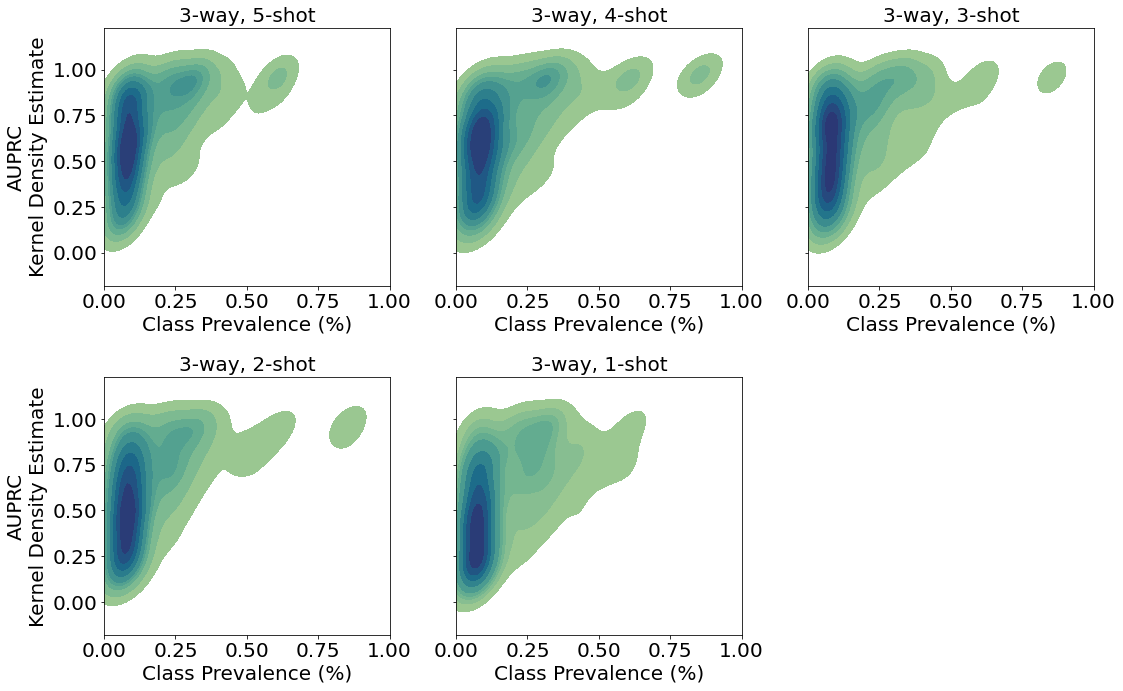

In [17]:
plt.rcParams['figure.autolayout'] = True
plt.clf()
fig, axs = plt.subplots(2, 3, figsize=(16, 10), sharex=False, sharey=True)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams.update({'font.size': 20})

m = 0
for i in range(2):
    if m == 5:
            break
    for j in range(3):
        if m == 5:
            break
        ax = axs[i, j]
        model = shot_var_models[m]
        m += 1
        sns.kdeplot(data=df[df["model"] == model], x="prevalence", y="auprc", fill=True,
                   alpha=1, ax=ax, cmap="crest", bw_adjust=1)
        ax.set_xlim(0, 1)
        ax.set_xlabel("Class Prevalence (%)")
        ax.set_ylabel("AUPRC\nKernel Density Estimate")
        ax.set_title(model, fontsize=20)  
    
for ax in axs.flat:
    ## check if something was plotted 
    if not bool(ax.has_data()):
        fig.delaxes(ax) ## delete if nothing is plotted in the axes obj

ax.figure.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "..","..", "..", "output/visualization/temp_new/host_multi_fsl_non_idv_3wayKshot_auprc_prevalence_kde_plot.pdf"))
plt.show()

<Figure size 432x288 with 0 Axes>

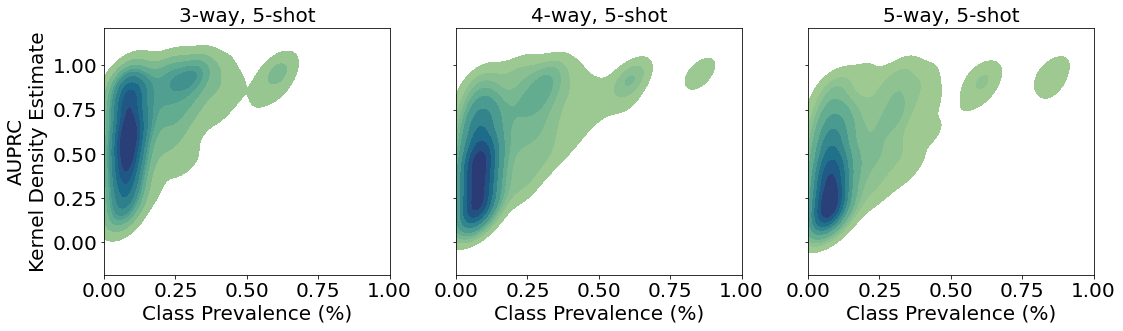

In [14]:
plt.rcParams['figure.autolayout'] = True
plt.clf()
fig, axs = plt.subplots(1, 3, figsize=(16, 5), sharex=False, sharey=True)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams.update({'font.size': 20})

for i, model in enumerate(way_var_models):
    ax = axs[i]
    sns.kdeplot(data=df[df["model"] == model], x="prevalence", y="auprc", fill=True,
               alpha=1, ax=ax, cmap="crest", bw_adjust=1)
    ax.set_xlim(0, 1)
    ax.set_xlabel("Class Prevalence (%)")
    ax.set_ylabel("AUPRC\nKernel Density Estimate")
    ax.set_title(model, fontsize=20)
    
    
for ax in axs.flat:
    ## check if something was plotted 
    if not bool(ax.has_data()):
        fig.delaxes(ax) ## delete if nothing is plotted in the axes obj

ax.figure.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "..","..", "..", "output/visualization/temp_new/host_multi_fsl_non_idv_Nway5shot_auprc_prevalence_kde_plot.pdf"))
plt.show()

<Figure size 432x288 with 0 Axes>

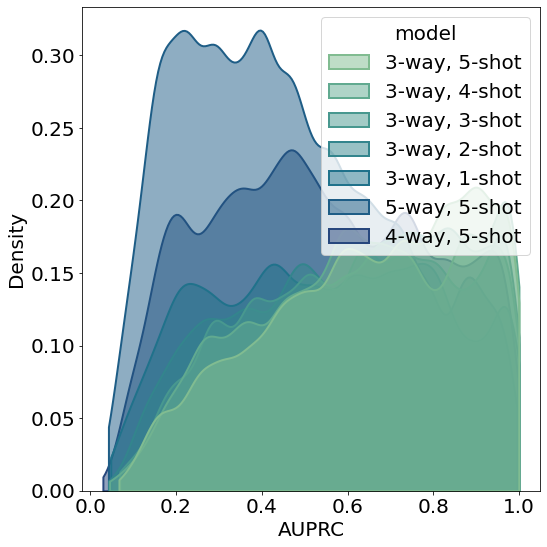

In [15]:
plt.clf()
plt.figure(figsize=(8,8))
plt.rcParams["figure.autolayout"] = True
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams.update({'font.size': 20})

ax = sns.kdeplot(data=df, x="auprc", hue="model", cut=0, bw_adjust=.5,
                  fill=True, palette="crest", alpha=.5, linewidth=2)

# ax = sns.scatterplot(mean_auprc_df, x="prevalance", y="auprc", hue="model", alpha=1)
ax.set_xlabel("AUPRC")
ax.set_ylabel("Density")

ax.figure.tight_layout()
#plt.savefig(os.path.join(os.getcwd(), "..","..", "..", "output/visualization/temp_new/host_multi_fsl_non_idv_3wayKshot_auprc_kde_plot.pdf"))
plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

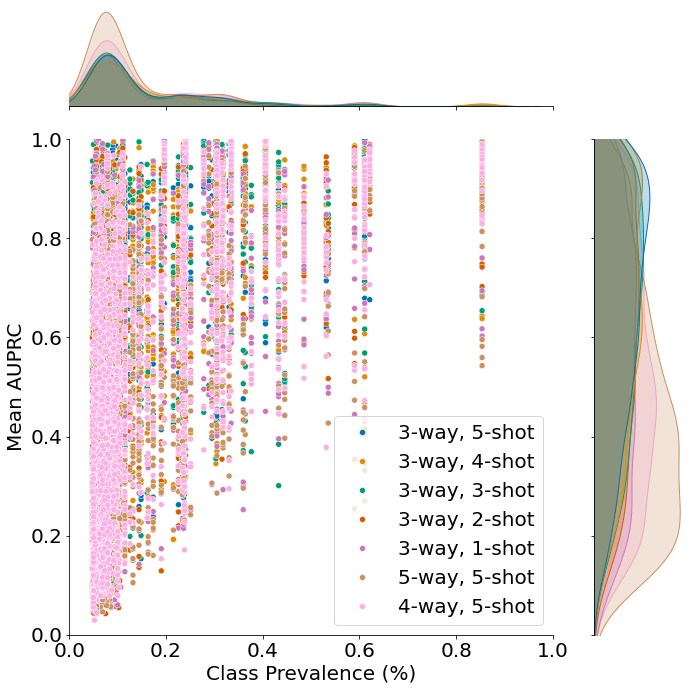

In [16]:
plt.clf()
plt.figure(figsize=(10,10))
plt.rcParams["figure.autolayout"] = True
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams.update({'font.size': 20})

ax = sns.jointplot(data=df, x="prevalence", y="auprc", hue="model",
                   height=10, ylim=(0, 1), alpha=1, xlim=(0, 1), palette="colorblind",
                   ratio=4)

# ax = sns.scatterplot(mean_auprc_df, x="prevalance", y="auprc", hue="model", alpha=1)
ax.ax_joint.set_xlabel("Class Prevalence (%)")
ax.ax_joint.set_ylabel("Mean AUPRC")

ax = plt.gca()
ax.legend()
ax.figure.tight_layout()
#plt.savefig(os.path.join(os.getcwd(), "..","..", "..", "output/visualization/temp_new/host_multi_fsl_non_idv_3wayKshot_auprc_prevalence_scatter_plot.pdf"))
plt.show()

In [15]:
df

,class,auprc,itr,model
0,Gorilla gorilla,0.228279,0,"3-way, 5-shot"
1,Mastomys natalensis,0.889177,0,"3-way, 5-shot"
2,Miniopterus pusillus,0.549528,0,"3-way, 5-shot"
3,Ailurus fulgens,0.984618,0,"3-way, 5-shot"
4,Gymnorhina tibicen,0.966904,0,"3-way, 5-shot"
...,...,...,...,...
395,Phoenicurus auroreus,0.577531,4,"4-way, 5-shot"
396,Bufo bufo,0.418547,4,"4-way, 5-shot"
397,Corynorhinus rafinesquii,0.322819,4,"4-way, 5-shot"
398,Mastomys natalensis,0.555695,4,"4-way, 5-shot"


In [ ]:
def get_p_value_annotation(p_value):
    if p_value > 5e-2 and p_value <= 1:
        return "ns"
    elif p_value > 1e-2 and p_value <= 5e-2:
        return "*"
    elif p_value > 1e-3 and p_value <= 1e-2:
        return "**"
    elif p_value > 1e-4 and p_value <= 1e-3:
        return "***"
    elif p_value <= 1e-4:
        return "****"
    else:
        return None

In [71]:
order=["5-way, 5-shot", "4-way, 5-shot", "3-way, 1-shot", "3-way, 2-shot", "3-way, 3-shot", "3-way, 4-shot", "3-way, 5-shot"]
pairs = [("3-way, 5-shot", "3-way, 4-shot"), 
         ("3-way, 5-shot", "3-way, 3-shot"), 
         ("3-way, 5-shot", "3-way, 2-shot"), 
         ("3-way, 5-shot", "3-way, 1-shot"), 
         ("3-way, 5-shot", "4-way, 5-shot"),
         ("3-way, 5-shot", "5-way, 5-shot")]

def get_p_value_annotation(p_value):
    if p_value > 5e-2 and p_value <= 1:
        return "ns"
    elif p_value > 1e-2 and p_value <= 5e-2:
        return "*"
    elif p_value > 1e-3 and p_value <= 1e-2:
        return "**"
    elif p_value > 1e-4 and p_value <= 1e-3:
        return "***"
    elif p_value <= 1e-4:
        return "****"
    else:
        return None
    
def plot_violinplot_w_stat_custom_annotation(df, metric, pairs, ylim):
    DEFAULT_FIGURE_CONFIG = {
        "figsize": (18, 8),
        "xtick.labelsize": 20,
        "ytick.labelsize": 20
    }
    color_palette = sns.cubehelix_palette(start=1, rot=-.9, hue=1, dark=.35, light=.85, n_colors=df["model"].nunique())
    visualization_utils.pre_plot_config(DEFAULT_FIGURE_CONFIG)
    ax = sns.violinplot(df, x="model", y="auprc", order=order, cut=0, palette=color_palette, bw_adjust=.7,
                       inner_kws=dict(box_width=15, whis_width=3, color=".5"), fill=True, linewidth=3)
    ax.set_xlabel("", size=0)
    ax.set_ylabel(metric.upper(), size=20)
    plt.draw()
    ax.set_ylim(*ylim)
    
    
    for i, pair in enumerate(pairs):
        model_1_values = df[df["model"] == pair[0]][metric].values
        model_2_values = df[df["model"] == pair[1]][metric].values
        p_value = mannwhitneyu(model_1_values, model_2_values, alternative="greater").pvalue
        formatted_pvalue = f"p={p_value:.2e}"
        print(f"{pair}: p-value={formatted_pvalue}")
        
        x_ticks = [t.get_text()  for t in ax.get_xticklabels()]
        x1 = order.index(pair[0])
        x2 = order.index(pair[1])
        y1 = max(df[df["model"] == pair[0]][metric].max(), 
                 df[df["model"] == pair[1]][metric].max()) + (0.05 * (i + 1))
        y2 = y1 + .02
        
        plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], lw=2, c="k")
        plt.text((x1 + x2)*.5, y1, get_p_value_annotation(p_value), ha='center', va='bottom', color="k", size="22")
    #visualization_utils.wrap_ticklabels(ax, axis="x", label_width=10, break_long_words=True)
    #plt.savefig(os.path.join(os.getcwd(), "..", "..", "..", "..", f"output/visualization/temp_new/host_multi_all_models_{metric}_boxplot_stat.pdf"), bbox_inches="tight")

    ax.figure.tight_layout()
    plt.savefig(os.path.join(os.getcwd(), "..","..", "..", "output/visualization/temp_new/host_multi_fsl_non_idv_NwayKshot_auprc_violin_plot_stats.pdf"))
    plt.show()

('3-way, 5-shot', '3-way, 4-shot'): p-value=p=1.27e-02
('3-way, 5-shot', '3-way, 3-shot'): p-value=p=1.92e-04
('3-way, 5-shot', '3-way, 2-shot'): p-value=p=9.55e-09
('3-way, 5-shot', '3-way, 1-shot'): p-value=p=1.77e-26
('3-way, 5-shot', '4-way, 5-shot'): p-value=p=5.25e-42
('3-way, 5-shot', '5-way, 5-shot'): p-value=p=1.05e-108


/tmp/ipykernel_3633737/2965215985.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(df, x="model", y="auprc", order=order, cut=0, palette=color_palette, bw_adjust=.7,


<Figure size 640x480 with 0 Axes>

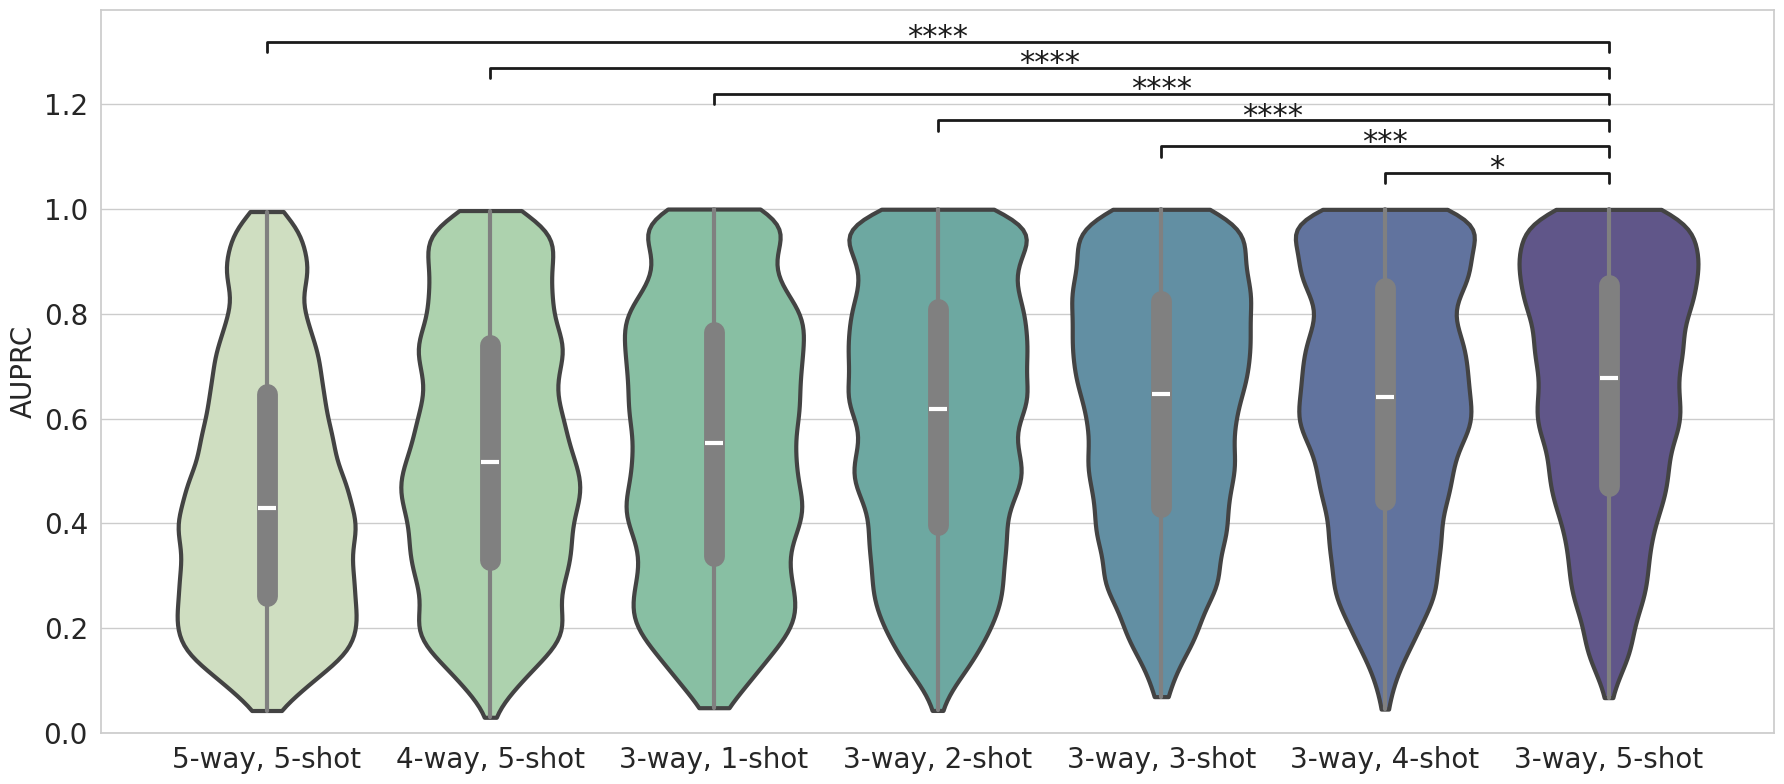

In [72]:
plot_violinplot_w_stat_custom_annotation(df, "auprc", pairs, ylim=(0, 1.38))

In [70]:
df[["model", "auprc"]].groupby("model").agg("mean")

,auprc
model,
"3-way, 1-shot",0.551199
"3-way, 2-shot",0.598756
"3-way, 3-shot",0.619708
"3-way, 4-shot",0.630267
"3-way, 5-shot",0.650489
"4-way, 5-shot",0.533765
"5-way, 5-shot",0.464044
